In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from pathlib import Path

# project modules
from predict import perform_inference
from datasets.rfw_latent import RFW_raw, RFW_latent, create_dataloaders
from train import train, write_model, save_model
from detection_models import MultiHeadResNet, LatentMultiHead_1
from latent_utils import get_latent
from RFW_utils import save_race_based_predictions_latent, load_predictions

# neural compression model
import sys
sys.path.append('/home/tianqiu/NeuralCompression/lossy-vae')
from lvae import get_model
from lvae.models.qresvae import zoo

In [6]:
DEVICE = 1
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device
n_keep = 12
# model_path = '../models/latent_RFW_numerical_all_labels_n_keep_1.pth'
model_path = '../models/latent_RFW_numerical_all_labels_resent18_retrain_n_keep_12.pth'
model_name = Path(model_path).stem # keep stem, remove parents and ext.
print(model_name)
model = torch.load(model_path).to(device)

latent_RFW_numerical_all_labels_resent18_retrain_n_keep_12


In [7]:
nc_model_name = 'qres17m'
lmb_value = 64
nc_model = get_model(nc_model_name, lmb_value, pretrained=True).to(device) # weights are downloaded automatically

In [8]:
BATCH_SIZE=32
RATIO=0.8

RFW_IMAGES_DIR =  "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64"
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
image_ds = RFW_raw(RFW_IMAGES_DIR, RFW_LABELS_DIR)
_, test_loader = create_dataloaders(
    image_ds,
    BATCH_SIZE, 
    RATIO
)

In [9]:
all_predictions, all_labels = save_race_based_predictions_latent(nc_model, 
                                                n_keep, 
                                                model,
                                                model_name,
                                                test_loader, 
                                                device, 
                                                '../results/latent_RFW/predictions',
                                            )

prediction_save_dir: ../results/latent_RFW/predictions


Getting Predictions: 100%|██████████| 254/254 [00:07<00:00, 32.08batch/s]


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

latent_prediction_metrics = {}
for race in all_predictions:
    latent_prediction_metrics[race] = {}
    for category in all_predictions[race]:
        latent_prediction_metrics[race][category] = {}
        
        preds = all_predictions[race][category]
        labels = all_labels[race][category]
        latent_prediction_metrics[race][category]['accuracy'] = accuracy_score(labels, preds)
        latent_prediction_metrics[race][category]['precision'] = precision_score(labels, preds, average='weighted')
        latent_prediction_metrics[race][category]['recall'] = recall_score(labels, preds, average='weighted')
        latent_prediction_metrics[race][category]['f1'] = f1_score(labels, preds, average='weighted')

/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2/lib/pyt

In [11]:
latent_prediction_metrics

{'Indian': {'skin_type': {'accuracy': 0.5438095238095239,
   'precision': 0.6272346851035137,
   'recall': 0.5438095238095239,
   'f1': 0.580005628265424},
  'eye_type': {'accuracy': 0.5752380952380952,
   'precision': 0.5701529868694047,
   'recall': 0.5752380952380952,
   'f1': 0.5632128001135266},
  'nose_type': {'accuracy': 0.6242857142857143,
   'precision': 0.6221309998397201,
   'recall': 0.6242857142857143,
   'f1': 0.623073298480574},
  'lip_type': {'accuracy': 0.9533333333333334,
   'precision': 0.9919171563324212,
   'recall': 0.9533333333333334,
   'f1': 0.9717009715544872},
  'hair_type': {'accuracy': 0.5671428571428572,
   'precision': 0.49880607068212124,
   'recall': 0.5671428571428572,
   'f1': 0.5146331669013049},
  'hair_color': {'accuracy': 0.6552380952380953,
   'precision': 0.42933696145124717,
   'recall': 0.6552380952380953,
   'f1': 0.5187615759767659}},
 'Caucasian': {'skin_type': {'accuracy': 0.43885254151987924,
   'precision': 0.4739826374698268,
   'recall

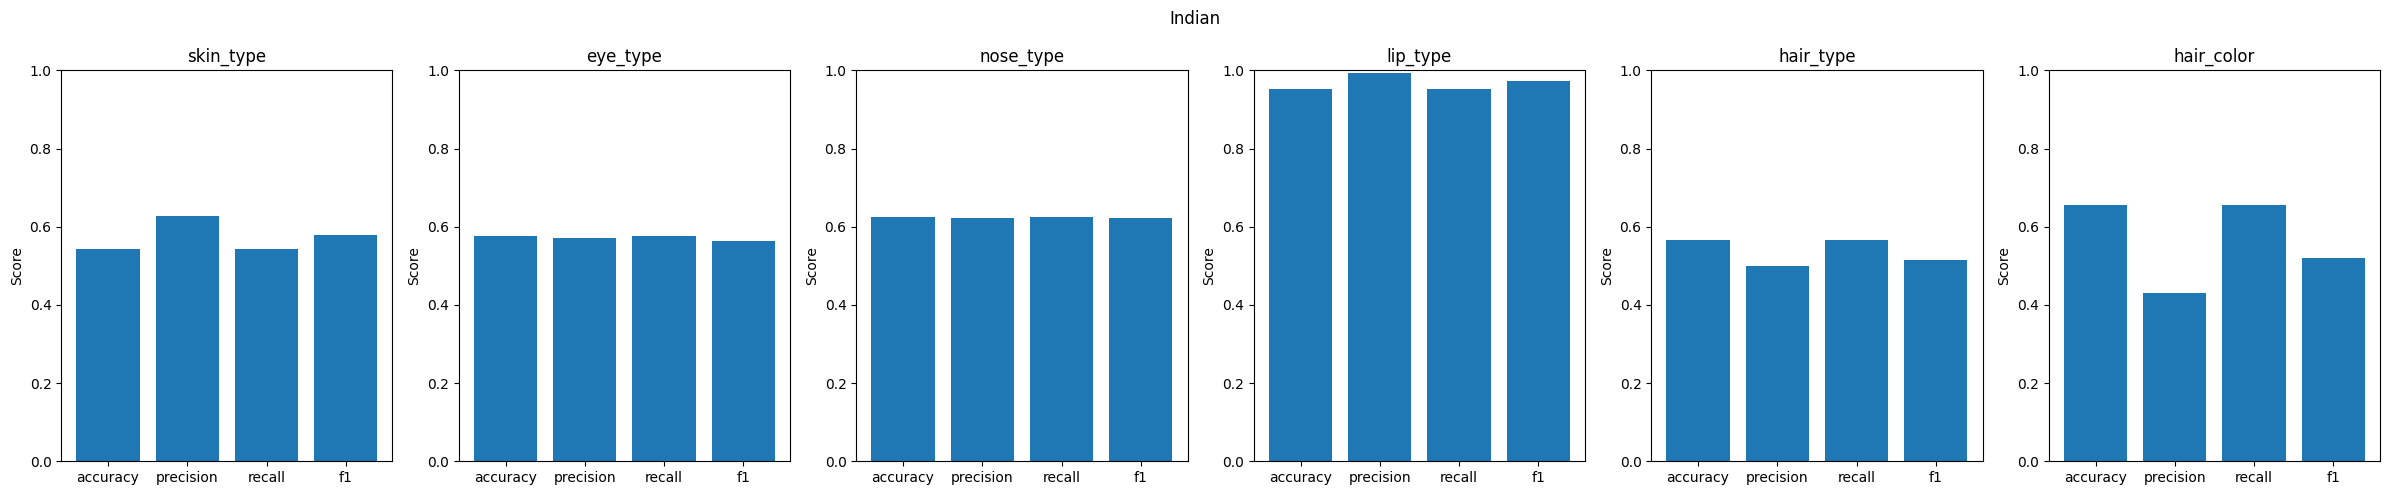

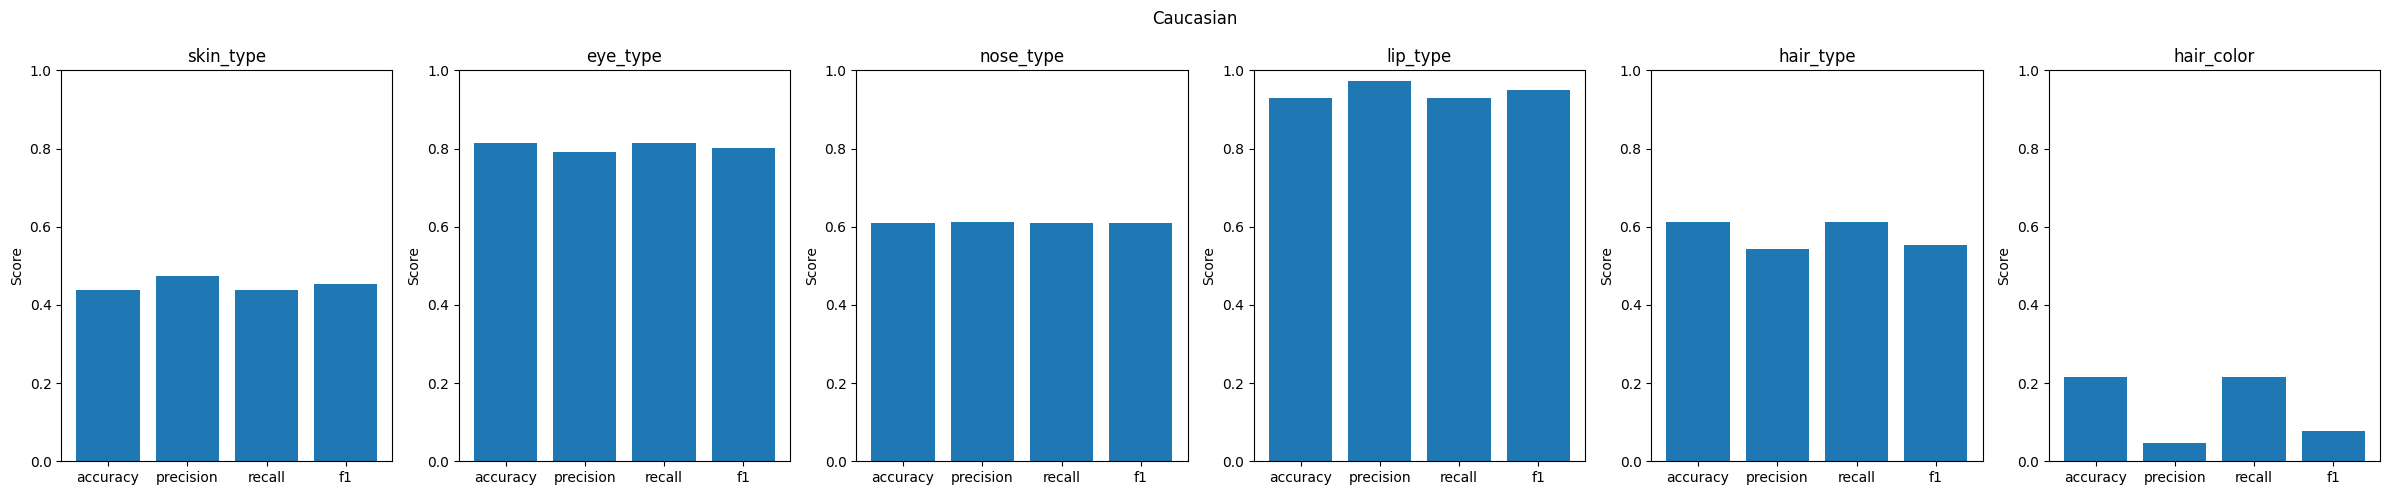

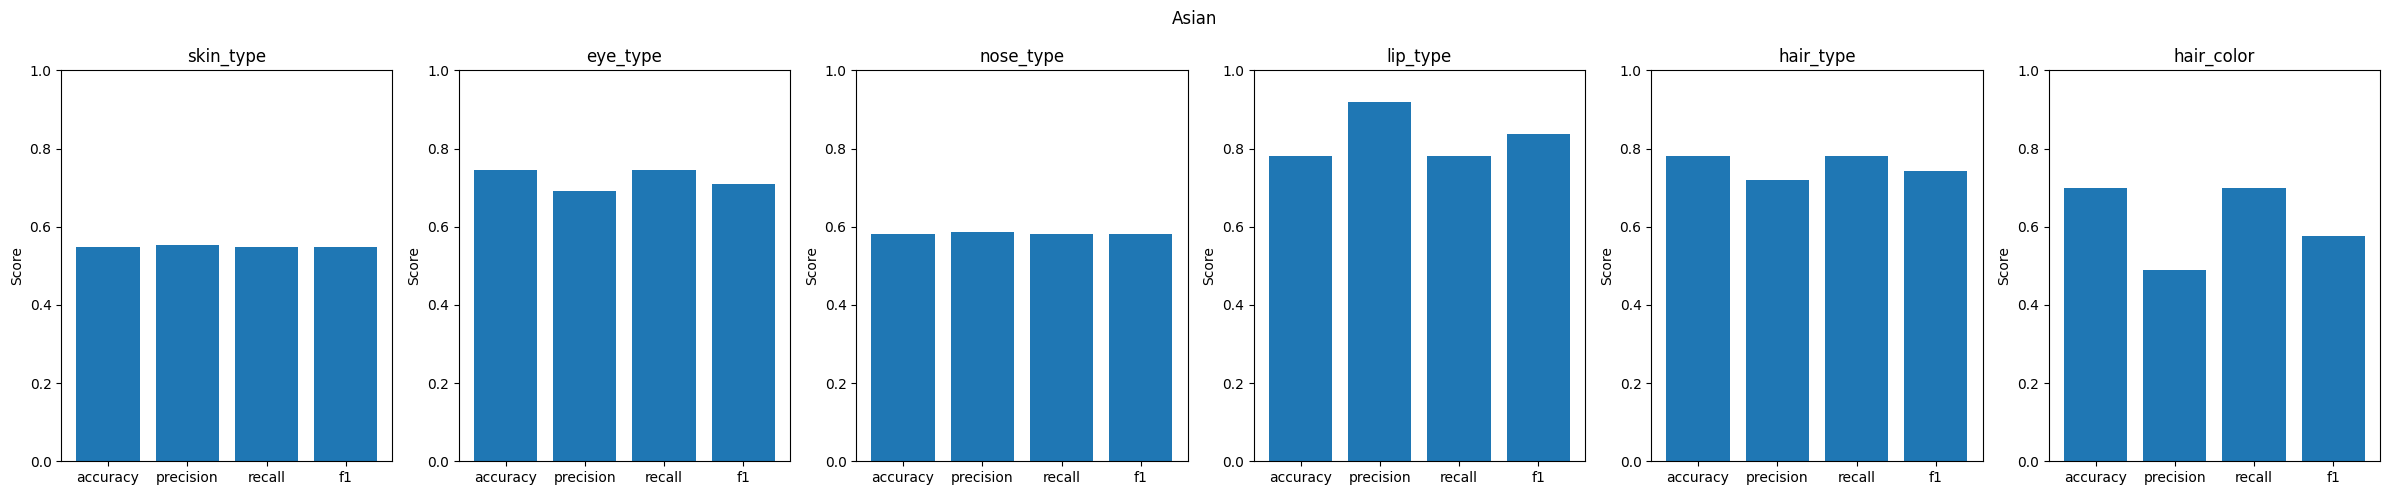

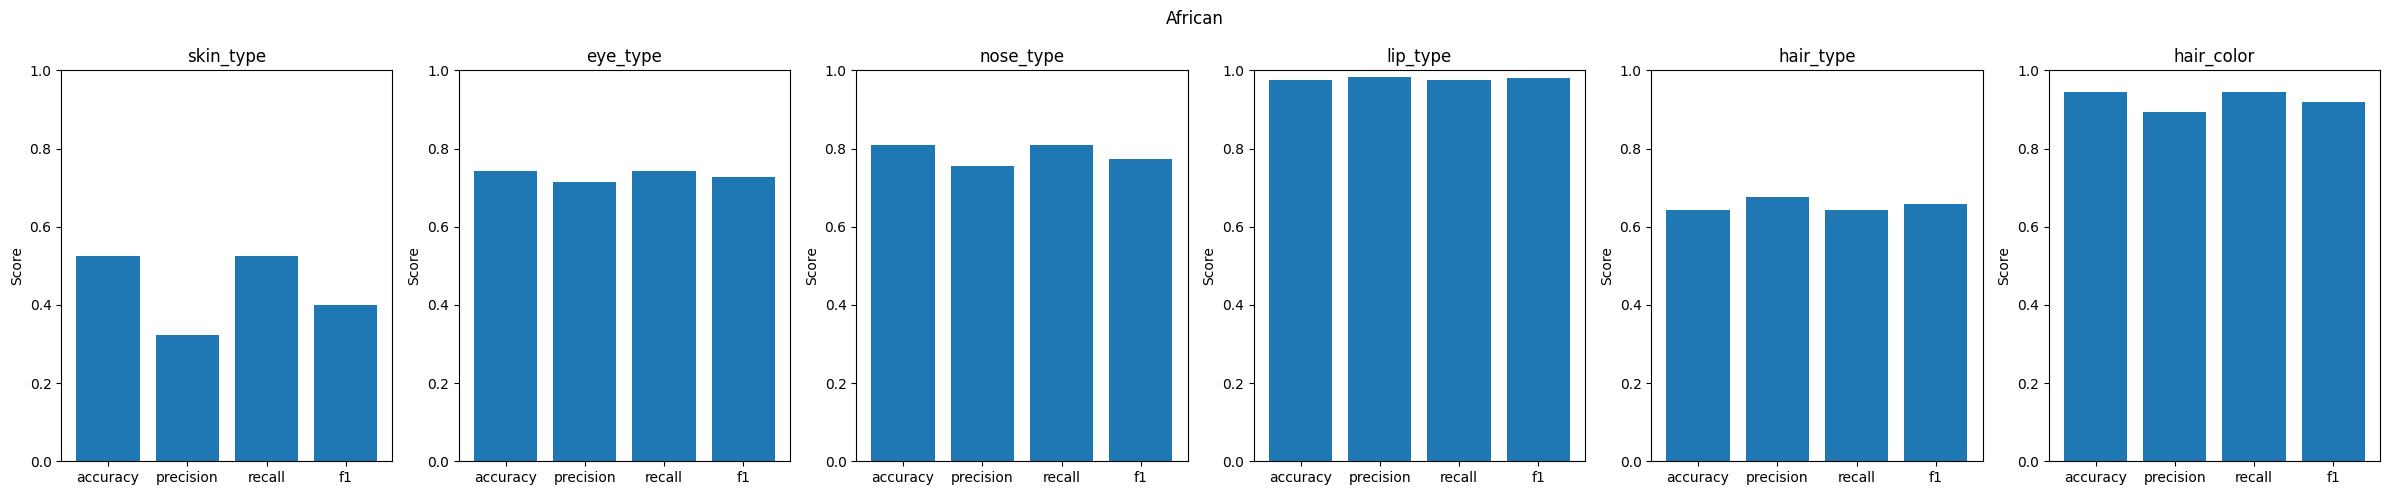

In [12]:
import matplotlib.pyplot as plt

for race in latent_prediction_metrics:
    
    fig, axs = plt.subplots(1, len(latent_prediction_metrics['Indian']), figsize=(24, 5))
    for i, (category, metrics) in enumerate(latent_prediction_metrics[race].items()):
        axs[i].bar(metrics.keys(), metrics.values())
        axs[i].set_title(category)
        axs[i].set_ylabel('Score')
        axs[i].set_ylim(0, 1)  # Limit y-axis to range [0, 1] for better visualization

    # plt.savefig(f'results/RFW/plots/baselines/baseline_{race}_results.png')
    plt.suptitle(race)
    plt.tight_layout()
    plt.show()

In [13]:
# compare with predictions from n_keep 1 images
image_predictions = load_predictions(model, 'RFW_numerical_all_labels_resnet18', '../results/RFW/predictions/progressive/q_64/12')
image_predictions

{'Indian': {'skin_type': tensor([1., 2., 4.,  ..., 2., 4., 2.]),
  'eye_type': tensor([1., 1., 1.,  ..., 1., 1., 1.]),
  'nose_type': tensor([0., 0., 1.,  ..., 0., 1., 0.]),
  'lip_type': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'hair_type': tensor([0., 3., 3.,  ..., 3., 3., 3.]),
  'hair_color': tensor([0., 0., 2.,  ..., 0., 0., 0.])},
 'Caucasian': {'skin_type': tensor([4., 2., 4.,  ..., 4., 4., 4.]),
  'eye_type': tensor([1., 1., 1.,  ..., 1., 1., 1.]),
  'nose_type': tensor([0., 1., 0.,  ..., 1., 1., 1.]),
  'lip_type': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'hair_type': tensor([3., 3., 3.,  ..., 3., 3., 3.]),
  'hair_color': tensor([2., 0., 2.,  ..., 2., 2., 2.])},
 'Asian': {'skin_type': tensor([4., 2., 2.,  ..., 4., 2., 4.]),
  'eye_type': tensor([1., 1., 0.,  ..., 1., 1., 1.]),
  'nose_type': tensor([1., 0., 0.,  ..., 1., 0., 1.]),
  'lip_type': tensor([1., 1., 0.,  ..., 1., 1., 0.]),
  'hair_type': tensor([3., 3., 3.,  ..., 3., 3., 3.]),
  'hair_color': tensor([0., 0., 0.,

In [14]:
image_prediction_metrics = {}
for race in image_predictions:
    image_prediction_metrics[race] = {}
    for category in image_predictions[race]:
        image_prediction_metrics[race][category] = {}
        
        preds = image_predictions[race][category]
        labels = all_labels[race][category]
        image_prediction_metrics[race][category]['accuracy'] = accuracy_score(labels, preds)
        image_prediction_metrics[race][category]['precision'] = precision_score(labels, preds, average='weighted')
        image_prediction_metrics[race][category]['recall'] = recall_score(labels, preds, average='weighted')
        image_prediction_metrics[race][category]['f1'] = f1_score(labels, preds, average='weighted')

/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tianqiu/.conda/envs/torch2_2

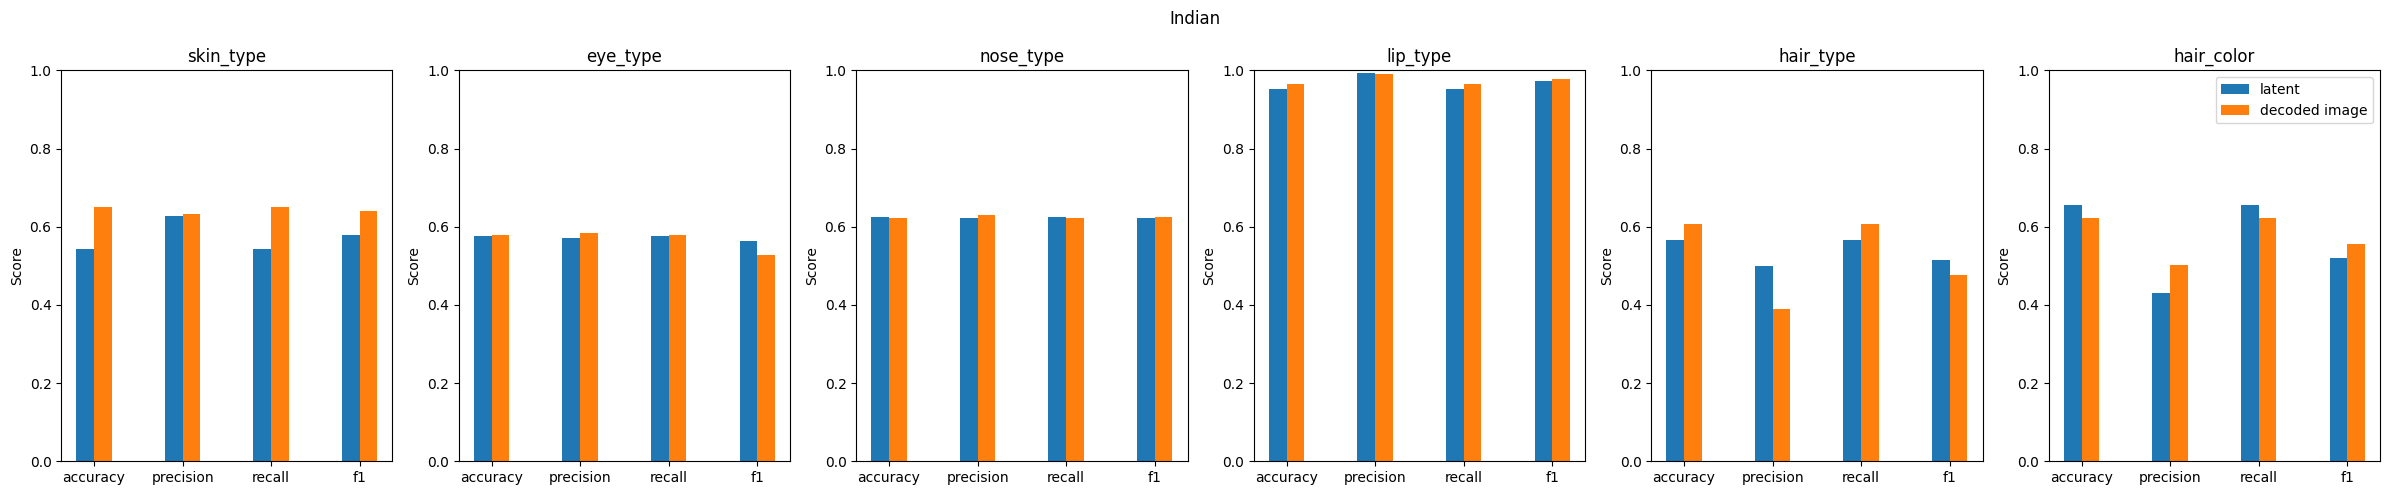

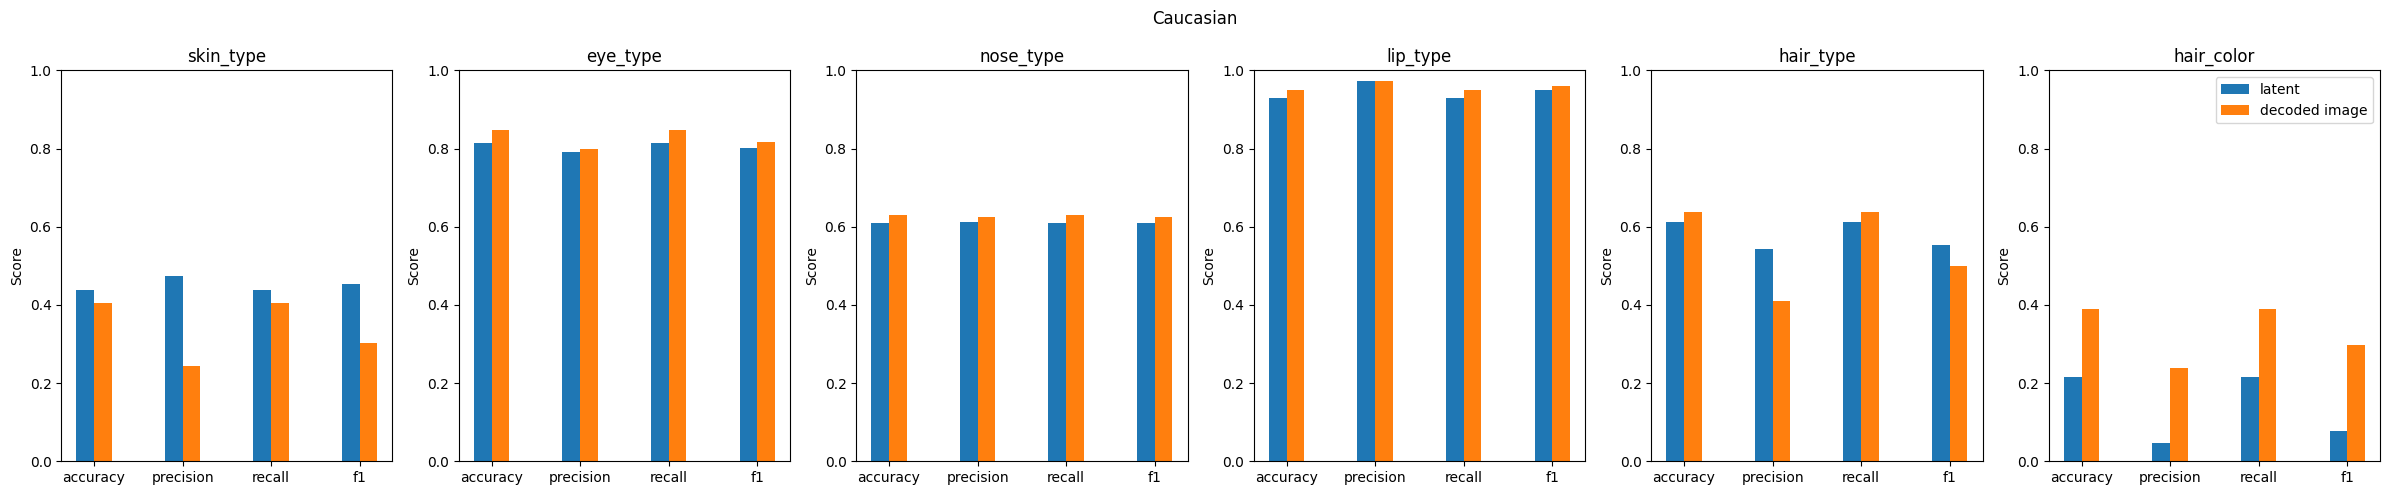

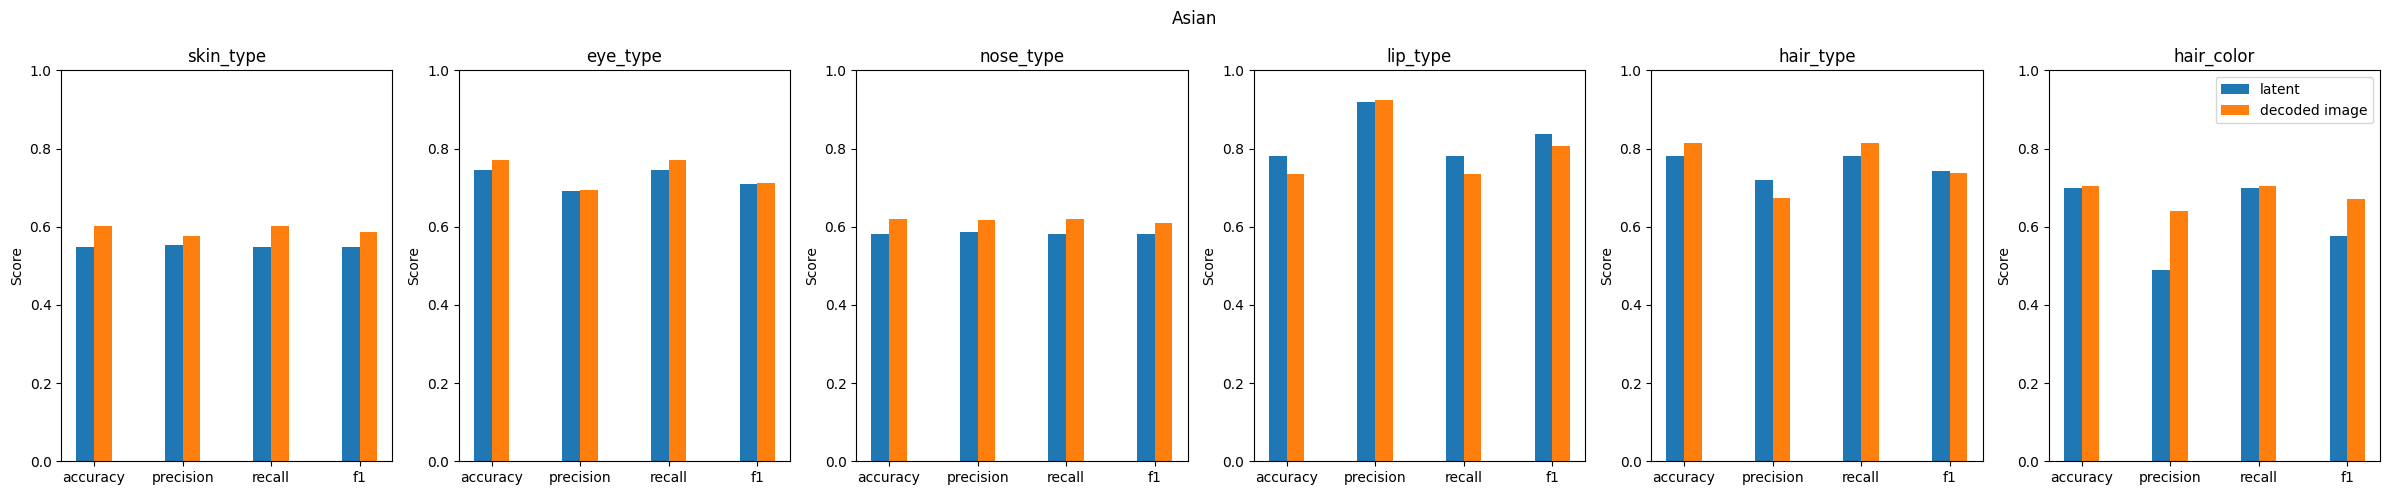

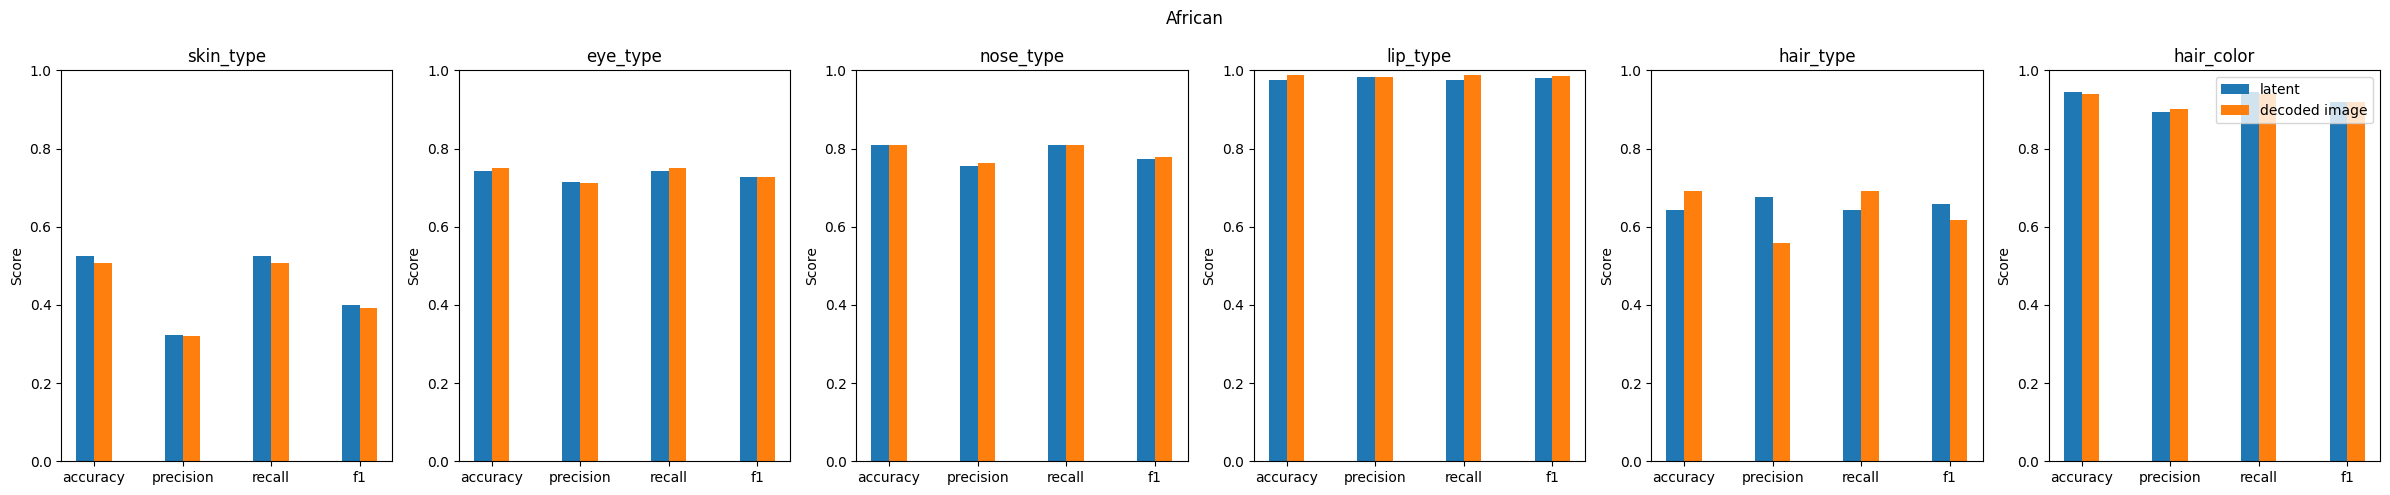

In [15]:
import numpy as np
ind = np.arange(4)
width = 0.2
for race in latent_prediction_metrics:
    
    fig, axs = plt.subplots(1, len(latent_prediction_metrics['Indian']), figsize=(24, 5))
    for i, ((category, latent_metrics), (_, image_metrics)) in enumerate(zip(latent_prediction_metrics[race].items(), image_prediction_metrics[race].items())):
        axs[i].bar(ind-0.1, latent_metrics.values(), width, label='latent')
        axs[i].bar(ind+0.1, image_metrics.values(), width, label='decoded image')
        axs[i].set_title(category)
        axs[i].set_ylabel('Score')
        axs[i].set_ylim(0, 1)  # Limit y-axis to range [0, 1] for better visualization
        axs[i].set_xticks(ind)
        axs[i].set_xticklabels(latent_metrics.keys())
    plt.legend(loc='best')
    plt.savefig(f'../results/latent_RFW/plots/progressive/n_keep_{n_keep}_{race}_comparison.png')
    plt.suptitle(race)
    plt.tight_layout()
    plt.show()